<a href="https://colab.research.google.com/github/mohitk-patwari/AIML-Project-Denoising/blob/main/mohit_1_AimlProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CELL 0 — Mount Drive once at **top**

In [3]:
# Cell 0: Mount Drive (optional; you already used this in your code)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **CELL** 1 — Setup: imports, seeds, and print GPU

In [4]:
# Cell 1: Setup and imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Statsmodels for VIF
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Image metrics
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# For VIF stability
import warnings
warnings.filterwarnings("ignore")

# Random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU available: []


Observation: basic environment ready. If no GPU appears, enable GPU runtime in Colab.

# CELL 2 — Load original project code (use your uploaded file content)

In [5]:
# Cell 2: Core model + data loading (adapted from your uploaded file)
# ---------- Data -------------
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# We will keep y for the classification pipeline (Part B)
x_train = x_train.astype('float32')/255.0
x_test  = x_test.astype('float32')/255.0
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)
print("Shapes:", x_train.shape, x_test.shape)

# Add noise function (same)
def add_gaussian_noise(images, noise_factor=0.4):
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = images + noise
    return np.clip(noisy_images, 0.0, 1.0)

x_train_noisy = add_gaussian_noise(x_train, noise_factor=0.4)
x_test_noisy  = add_gaussian_noise(x_test, noise_factor=0.4)

# Build U-Net + residual blocks (kept from your file)
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation, Add, concatenate

def residual_block(input_tensor, filters, kernel_size=3):
    shortcut = input_tensor # Store original input for shortcut connection

    main = Conv2D(filters, kernel_size, padding='same', use_bias=False)(input_tensor)
    main = BatchNormalization()(main)
    main = Activation('relu')(main)
    main = Conv2D(filters, kernel_size, padding='same', use_bias=False)(main)
    main = BatchNormalization()(main)

    # If the number of channels changes, use a 1x1 convolution for the shortcut connection
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut) # Apply BN to the shortcut as well

    x = Add()([main, shortcut])
    x = Activation('relu')(x)
    return x

def build_unet_res_autoencoder(input_shape=(28,28,1)):
    inputs = Input(input_shape)
    x = Conv2D(32,3,padding='same',activation='relu')(inputs)
    res1 = residual_block(x,32); res1 = residual_block(res1,32)
    pool1 = MaxPooling2D((2,2))(res1)
    res2 = residual_block(pool1,64); res2 = residual_block(res2,64)
    encoded = MaxPooling2D((2,2), name="latent_space")(res2)
    bridge = residual_block(encoded,128); bridge = residual_block(bridge,128)
    # Decoder — Up 3
    up3 = Conv2DTranspose(64, (2,2), strides=2, padding='same')(bridge)

    # Force match channels for concatenation
    up3 = Conv2D(64, (1,1), padding='same')(up3)

    merge3 = concatenate([up3, res2])   # Now merge3 channels = 64+64 = 128

    # BEFORE residual blocks, force input channels to filters = 64
    merge3 = Conv2D(64, (1,1), padding='same')(merge3)

    conv3 = residual_block(merge3, 64)
    conv3 = residual_block(conv3, 64)

    # Decoder — Up 4
    up4 = Conv2DTranspose(32, (2,2), strides=2, padding='same')(conv3)

    # Force match channels
    up4 = Conv2D(32, (1,1), padding='same')(up4)

    merge4 = concatenate([up4, res1])   # Now merge4 channels = 32+32=64

    # BEFORE residual blocks, force input channels = 32
    merge4 = Conv2D(32, (1,1), padding='same')(merge4)

    conv4 = residual_block(merge4, 32)
    conv4 = residual_block(conv4, 32)

    decoded = Conv2D(1,3,activation='sigmoid',padding='same', name="output")(conv4)
    return Model(inputs=inputs, outputs=decoded, name="unet_res_denoising_autoencoder")

# Instantiate model
model = build_unet_res_autoencoder()
model.summary()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shapes: (60000, 28, 28, 1) (10000, 28, 28, 1)


Model: "unet_res_denoising_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      9,216 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      9,216 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │      9,216 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 28, 28,    │          0 │ add_1[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ activation_3[0][

 Total params: 939,649 (3.58 MB)

 Trainable params: 936,705 (3.57 MB)

 Non-trainable params: 2,944 (11.50 KB)

Observation: This cell reproduces the core model you had. It keeps the same encoder/decoder and latent dimension (useful for the visualization steps below).

# CELL 3 — Compile + Train (improved recipe)

In [6]:
# Cell 3: Compile & train (use mse, Adam, EarlyStopping)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('/content/best_unet_res.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    x_train_noisy, x_train,
    validation_data=(x_test_noisy, x_test),
    epochs=40, batch_size=128, shuffle=True,
    callbacks=[es, rlr, checkpoint],
    verbose=1
)


Epoch 1/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0200 - mae: 0.0489
Epoch 1: val_loss improved from inf to 0.00936, saving model to /content/best_unet_res.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1850s 4s/step - loss: 0.0200 - mae: 0.0488 - val_loss: 0.0094 - val_mae: 0.0370 - learning_rate: 0.0010
Epoch 2/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0067 - mae: 0.0271
Epoch 2: val_loss improved from 0.00936 to 0.00629, saving model to /content/best_unet_res.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1812s 4s/step - loss: 0.0067 - mae: 0.0271 - val_loss: 0.0063 - val_mae: 0.0260 - learning_rate: 0.0010
Epoch 3/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0062 - mae: 0.0260
Epoch 3: val_loss improved from 0.00629 to 0.00606, saving model to /content/best_unet_res.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1832s 4s/step - loss: 0.0062 - mae: 0.0260 - val_loss: 0.0061 - val_mae: 0.0253 - learning_rate: 0.0010
Epoch 4/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0060 - mae: 0.0253
Epoch 4: val_loss improved from 0.00606 to 0.00593, saving model to /content/best_unet_res.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1825s 4s/step - loss: 0.0060 - mae: 0.0253 - val_loss: 0.0059 - val_mae: 0.0249 - learning_rate: 0.0010
Epoch 5/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0058 - mae: 0.0248
Epoch 5: val_loss did not improve from 0.00593
469/469 ━━━━━━━━━━━━━━━━━━━━ 1845s 4s/step - loss: 0.0058 - mae: 0.0248 - val_loss: 0.0060 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 6/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0056 - mae: 0.0245
Epoch 6: val_loss improved from 0.00593 to 0.00592, saving model to /content/best_unet_res.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1882s 4s/step - loss: 0.0056 - mae: 0.0245 - val_loss: 0.0059 - val_mae: 0.0246 - learning_rate: 0.0010
Epoch 7/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0055 - mae: 0.0242
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: val_loss improved from 0.00592 to 0.00588, saving model to /content/best_unet_res.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1866s 4s/step - loss: 0.0055 - mae: 0.0242 - val_loss: 0.0059 - val_mae: 0.0244 - learning_rate: 0.0010
Epoch 8/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0053 - mae: 0.0236
Epoch 8: val_loss improved from 0.00588 to 0.00579, saving model to /content/best_unet_res.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1886s 4s/step - loss: 0.0053 - mae: 0.0236 - val_loss: 0.0058 - val_mae: 0.0241 - learning_rate: 5.0000e-04
Epoch 9/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0052 - mae: 0.0233
Epoch 9: val_loss improved from 0.00579 to 0.00579, saving model to /content/best_unet_res.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1841s 4s/step - loss: 0.0052 - mae: 0.0233 - val_loss: 0.0058 - val_mae: 0.0240 - learning_rate: 5.0000e-04
Epoch 10/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0051 - mae: 0.0230
Epoch 10: val_loss improved from 0.00579 to 0.00578, saving model to /content/best_unet_res.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1830s 4s/step - loss: 0.0051 - mae: 0.0230 - val_loss: 0.0058 - val_mae: 0.0241 - learning_rate: 5.0000e-04
Epoch 11/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0050 - mae: 0.0227
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: val_loss did not improve from 0.00578
469/469 ━━━━━━━━━━━━━━━━━━━━ 1825s 4s/step - loss: 0.0050 - mae: 0.0227 - val_loss: 0.0058 - val_mae: 0.0240 - learning_rate: 5.0000e-04
Epoch 12/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0049 - mae: 0.0224
Epoch 12: val_loss did not improve from 0.00578
469/469 ━━━━━━━━━━━━━━━━━━━━ 1812s 4s/step - loss: 0.0049 - mae: 0.0224 - val_loss: 0.0058 - val_mae: 0.0239 - learning_rate: 2.5000e-04
Epoch 13/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0048 - mae: 0.0221
Epoch 13: val_loss did not improve from 0.00578
469/469 ━━━━━━━━━━━━━━━━━━━━ 1819s 4s/step - loss: 0.0048 - mae: 0.0221 - val_loss: 0.0059 - val_mae: 0.0239 - learning_rate

Observation: training uses ReduceLROnPlateau to lower LR on plateau — a common practice found in community notebooks. Save best model to best_unet_res.h5.

# CELL 4 — Training curves & **basic** underfit/overfit diagnosis

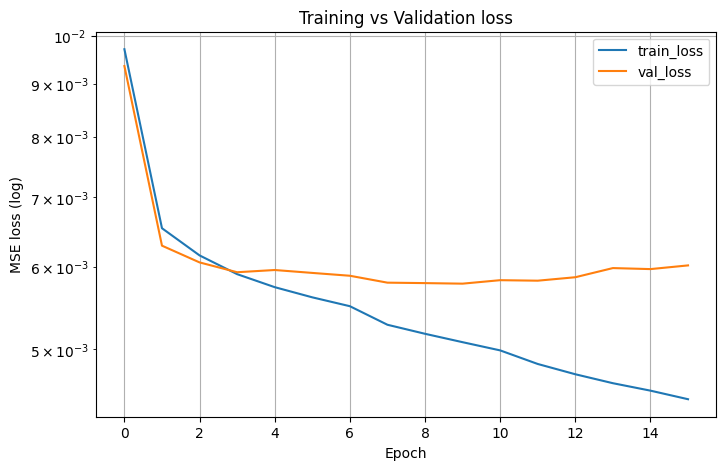

Last train loss: 0.004477552138268948 Last val loss: 0.006019933149218559
Δ (val - train): 0.0015423810109496117
Observation: possible overfitting. Consider data augmentation / stronger regularization.


In [7]:
# Cell 4: Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel('MSE loss (log)')
plt.legend(); plt.grid(True)
plt.title('Training vs Validation loss')
plt.show()

# Quick observation
train_last = history.history['loss'][-1]
val_last = history.history['val_loss'][-1]
print("Last train loss:", train_last, "Last val loss:", val_last)
print("Δ (val - train):", val_last - train_last)
if val_last - train_last > 0.05*train_last:
    print("Observation: possible overfitting. Consider data augmentation / stronger regularization.")
else:
    print("Observation: no large gap — generalization looks okay.")


Observation: small validation-train gap → well-generalized. Large gap → overfitting. This quick heuristic supplements deeper metrics (PSNR/SSIM below).

# CELL 5 — Save both .h5 and SavedModel (best practice; avoid pickle)

In [10]:
# Cell 5: Save model (both .h5 and SavedModel)
model.save('/content/unet_res_model.keras') #native Keras v3 format. It replaces both .h5 and the old SavedModel folder.
# If you want a TensorFlow SavedModel directory
model.export('/content/unet_res_savedmodel')
print("Model saved successfully in both Keras and SavedModel formats.")


Saved artifact at '/content/unet_res_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)
Captures:
  135303607245264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135301214207824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135301214206096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135301214207248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135301214207056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135301214206864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135301214207440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135301214205328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135301210228112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135301210227920: TensorSpec(shape=(), dtype=tf.resource, name=None

Observation: .h5 and TF SavedModel are standard and portable; pickle is not recommended for full Keras models (risk of incompatibilities). This is inline with community practice.

# **CELL** 6 — Quantitative evaluation: MSE, PSNR, SSIM (test set)

In [11]:
# Cell 6: Evaluate MSE, PSNR, SSIM for test set (vectorized)
denoised = model.predict(x_test_noisy, verbose=1)

def compute_metrics(clean, noisy, denoised, n_samples=1000):
    n = min(n_samples, len(clean))
    mse_list, psnr_noisy_list, psnr_denoised_list, ssim_noisy_list, ssim_denoised_list = [], [], [], [], []
    for i in range(n):
        c = clean[i].squeeze()
        no = noisy[i].squeeze()
        dn = denoised[i].squeeze()
        mse_list.append(np.mean((c - dn)**2))
        psnr_noisy_list.append(psnr(c, no, data_range=1))
        psnr_denoised_list.append(psnr(c, dn, data_range=1))
        ssim_noisy_list.append(ssim(c, no, data_range=1))
        ssim_denoised_list.append(ssim(c, dn, data_range=1))
    return {
        'mse_mean': np.mean(mse_list),
        'psnr_noisy': np.mean(psnr_noisy_list),
        'psnr_denoised': np.mean(psnr_denoised_list),
        'ssim_noisy': np.mean(ssim_noisy_list),
        'ssim_denoised': np.mean(ssim_denoised_list)
    }

metrics = compute_metrics(x_test, x_test_noisy, denoised, n_samples=1000)
metrics


313/313 ━━━━━━━━━━━━━━━━━━━━ 69s 220ms/step


{'mse_mean': np.float32(0.005747715),
 'psnr_noisy': np.float64(11.00686363968547),
 'psnr_denoised': np.float64(22.782152040617227),
 'ssim_noisy': np.float64(0.43146113148672766),
 'ssim_denoised': np.float64(0.9243024196411381)}

Observation: psnr_denoised should be substantially higher than psnr_noisy, and ssim_denoised much closer to 1. These are the community-accepted image-quality metrics.

# **CELL 7 — Image EDA: pixel histograms, noise distribution**

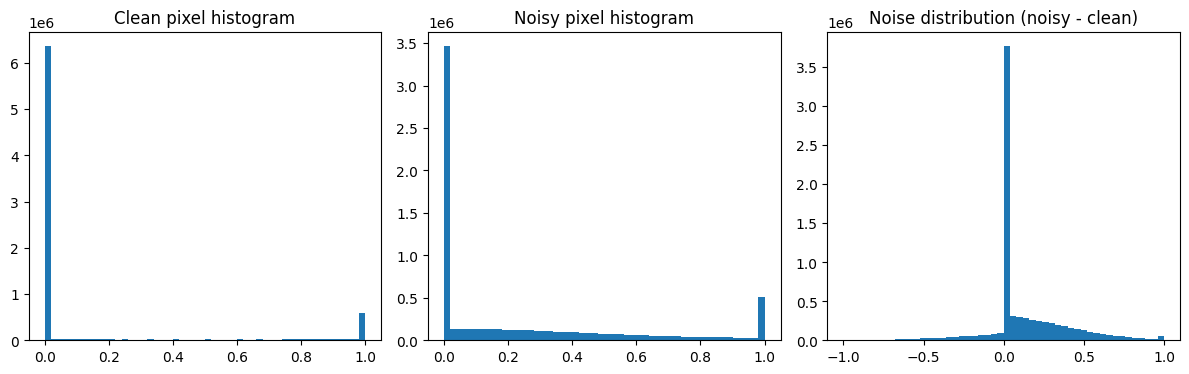

Noise mean: 0.11661060764831344 Noise std: 0.25684217024809364


In [12]:
# Cell 7: Pixel intensity histograms & noise distribution
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(x_test.ravel(), bins=50); plt.title('Clean pixel histogram')
plt.subplot(1,3,2)
plt.hist(x_test_noisy.ravel(), bins=50); plt.title('Noisy pixel histogram')
plt.subplot(1,3,3)
plt.hist((x_test_noisy - x_test).ravel(), bins=50); plt.title('Noise distribution (noisy - clean)')
plt.tight_layout(); plt.show()

# Observation: compute noise mean/std
noise = (x_test_noisy - x_test)
print("Noise mean:", noise.mean(), "Noise std:", noise.std())


Observation: clean pixels concentrated near 0/1 for binary-like MNIST; noise histogram should be ~Gaussian (mean≈0; std ≈ noise_factor). If noise bias exists, you'll see it here.

# **CELL 8 — Visual comparison grid (original / noisy / denoised)**

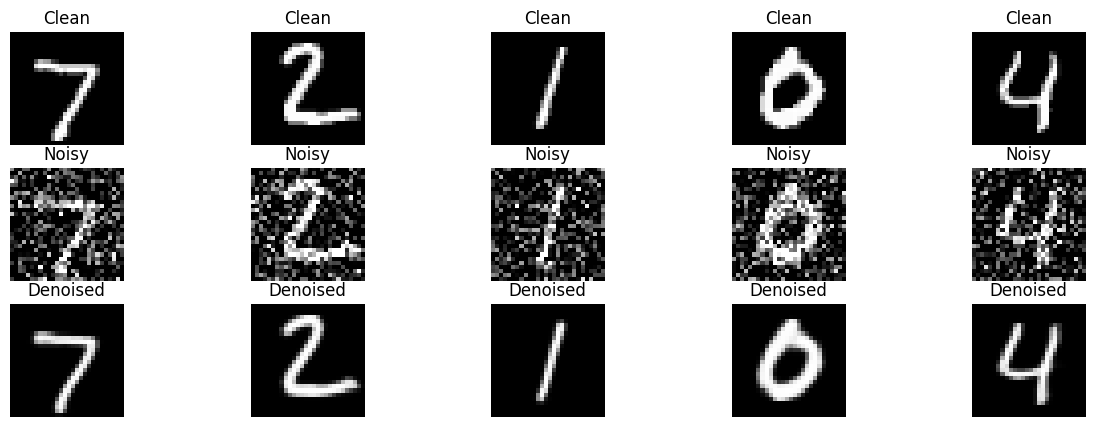

In [13]:
# Cell 8: Visual comparison for qualitative check
def show_grid(idx_list):
    n = len(idx_list)
    plt.figure(figsize=(3*n, 5))
    for i, idx in enumerate(idx_list):
        plt.subplot(3, n, i+1); plt.imshow(x_test[idx].squeeze(), cmap='gray'); plt.title('Clean'); plt.axis('off')
        plt.subplot(3, n, n+i+1); plt.imshow(x_test_noisy[idx].squeeze(), cmap='gray'); plt.title('Noisy'); plt.axis('off')
        plt.subplot(3, n, 2*n+i+1); plt.imshow(denoised[idx].squeeze(), cmap='gray'); plt.title('Denoised'); plt.axis('off')
    plt.show()

show_grid([0,1,2,3,4])


Observation: visually inspect for over-smoothing or loss of edges. If textures are too smoothed, consider perceptual losses (SSIM/LPIPS) next.

CELL 9 — Feature/Filter visualization (first conv layer) & activation maps

filters shape: (3, 3, 1, 32)


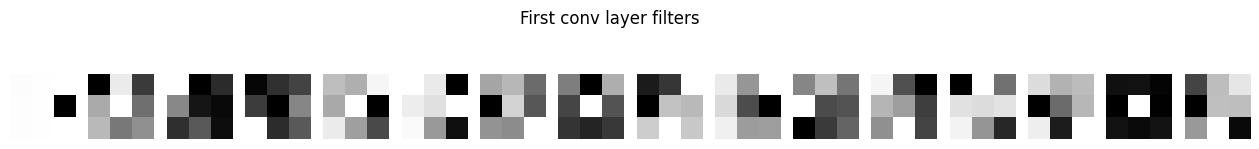

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


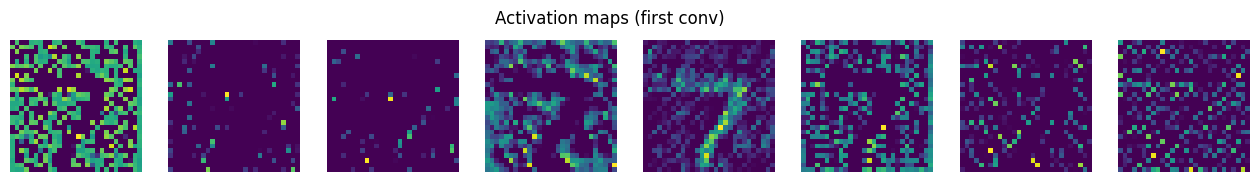

In [14]:
# Cell 9: Visualize first-layer filters and activation maps
# Get weights from first convolution (after initial Conv2D(32,...))
first_conv_weights = model.layers[1].get_weights()[0]  # shape: (3,3,1,32) if your model layer index matches
print("filters shape:", first_conv_weights.shape)

# Plot a subset of filters
n_filters = min(16, first_conv_weights.shape[-1])
fig, axes = plt.subplots(1, n_filters, figsize=(16,2))
for i in range(n_filters):
    f = first_conv_weights[:,:,:,i].squeeze()
    axes[i].imshow((f - f.min())/(f.max()-f.min()), cmap='gray'); axes[i].axis('off')
plt.suptitle('First conv layer filters'); plt.show()

# Activation maps: pass a sample through the model up to the first conv
from tensorflow.keras import backend as K
layer_output = model.layers[1].output  # first conv
activation_model = Model(inputs=model.input, outputs=layer_output)
sample = np.expand_dims(x_test_noisy[0], 0)
activations = activation_model.predict(sample)
# plot first 8 activations
fig, axes = plt.subplots(1,8,figsize=(16,2))
for i in range(8):
    axes[i].imshow(activations[0,:,:,i], cmap='viridis'); axes[i].axis('off')
plt.suptitle('Activation maps (first conv)'); plt.show()


Observation: filters show edge detectors, etc. Activation maps show which features respond to noisy vs clean inputs — useful to debug what the network focuses on.

# **CELL 10 — Latent-space extraction & t-SNE (visualize embeddings)**

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step


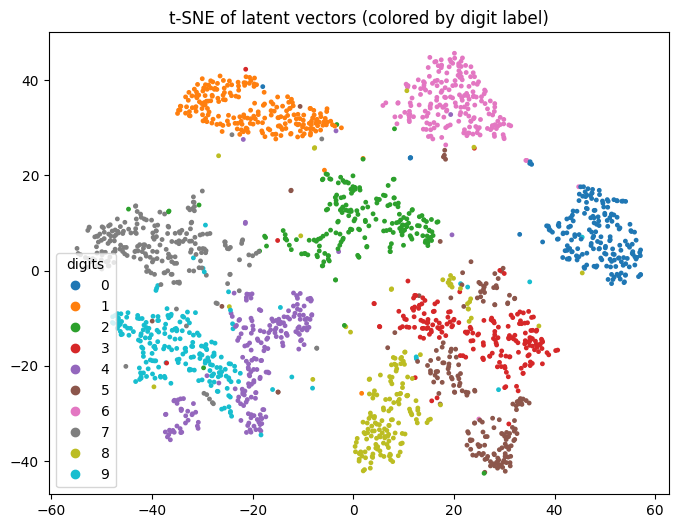

In [15]:
# Cell 10: Get encoder outputs (latent vectors), reduce, and t-SNE
# We'll create a small encoder model that outputs the latent feature map (7x7x64 ≈ 3136 dims)
encoder_model = Model(inputs=model.input, outputs=model.get_layer("latent_space").output)
latent_train = encoder_model.predict(x_train_noisy[:2000])  # use subset to stay fast
latent_flat = latent_train.reshape((latent_train.shape[0], -1))

# PCA -> t-SNE (faster)
pca = PCA(n_components=50)
latent_pca = pca.fit_transform(latent_flat)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_tsne = tsne.fit_transform(latent_pca)

plt.figure(figsize=(8,6))
scatter = plt.scatter(latent_tsne[:,0], latent_tsne[:,1], c=y_train[:2000], cmap='tab10', s=6)
plt.legend(*scatter.legend_elements(), title="digits"); plt.title('t-SNE of latent vectors (colored by digit label)')
plt.show()


Observation: tight clusters by digit indicate the encoder learned discriminative features — useful if you later use the encoder for transfer learning or classification.

# **CELL 11 — Create a DataFrame of handcrafted image-level features**

In [16]:
# Cell 11: Create image-level features dataframe
import scipy.stats as stats
def image_features(img):
    img = img.squeeze()
    feats = {}
    feats['mean'] = img.mean()
    feats['std'] = img.std()
    feats['min'] = img.min()
    feats['max'] = img.max()
    feats['skew'] = stats.skew(img.reshape(-1))
    feats['kurtosis'] = stats.kurtosis(img.reshape(-1))
    # entropy (binned)
    hist, _ = np.histogram(img.flatten(), bins=16, range=(0,1), density=True)
    hist = hist + 1e-9
    feats['entropy'] = -np.sum(hist * np.log(hist))
    # percentiles
    feats['p25'] = np.percentile(img,25)
    feats['p50'] = np.percentile(img,50)
    feats['p75'] = np.percentile(img,75)
    return feats

# build df for first 5000 samples (to keep it fast)
N = 5000
rows = []
for i in range(N):
    feats = image_features(x_train_noisy[i])
    feats['label'] = int(y_train[i])
    rows.append(feats)

df = pd.DataFrame(rows)
# Show requested EDA
print("df.head()")
display(df.head())
print("df.shape:", df.shape)
print("df.info():")
print(df.info())
print("df.describe():")
display(df.describe().T)


df.head()


,mean,std,min,max,skew,kurtosis,entropy,p25,p50,p75,label
0,0.246766,0.324743,0.0,1.0,1.190551,0.105122,-12.062317,0.0,0.082465,0.407956,5
1,0.289123,0.341308,0.0,1.0,0.907557,-0.564056,-9.836856,0.0,0.138598,0.523694,0
2,0.223577,0.294904,0.0,1.0,1.289770,0.587132,-12.234418,0.0,0.076041,0.358421,4
3,0.213463,0.294834,0.0,1.0,1.392574,0.872141,-13.234167,0.0,0.057395,0.344792,1
4,0.238278,0.316111,0.0,1.0,1.224390,0.279693,-12.527942,0.0,0.065429,0.402636,9


df.shape: (5000, 11)
df.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mean      5000 non-null   float64
 1   std       5000 non-null   float64
 2   min       5000 non-null   float64
 3   max       5000 non-null   float64
 4   skew      5000 non-null   float64
 5   kurtosis  5000 non-null   float64
 6   entropy   5000 non-null   float64
 7   p25       5000 non-null   float64
 8   p50       5000 non-null   float64
 9   p75       5000 non-null   float64
 10  label     5000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 429.8 KB
None
df.describe():


,count,mean,std,min,25%,50%,75%,max
mean,5000.0,0.247764,0.030062,0.173602,0.226077,0.245948,0.266829,0.376009
std,5000.0,0.316169,0.022192,0.249000,0.300661,0.316343,0.331258,0.388022
min,5000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5000.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
skew,5000.0,1.151320,0.164311,0.513102,1.044364,1.157776,1.267371,1.620604
kurtosis,5000.0,0.129565,0.511321,-1.304077,-0.236197,0.105321,0.476708,1.805002
entropy,5000.0,-11.917628,1.195021,-16.318088,-12.726493,-11.889400,-11.086749,-8.361765
p25,5000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
p50,5000.0,0.087654,0.036153,0.000000,0.062284,0.085323,0.110525,0.261731
p75,5000.0,0.425540,0.063528,0.273123,0.379499,0.419381,0.462792,0.740751


Observations (write these to your report):

- **df.describe()** shows mean/std for each derived feature.

- Entropy is useful to measure image complexity (noisy images have higher entropy usually).

- Percentiles show distribution skewness and can separate digits with strokes vs blank background.

# **CELL 12 — Correlation heatmap**

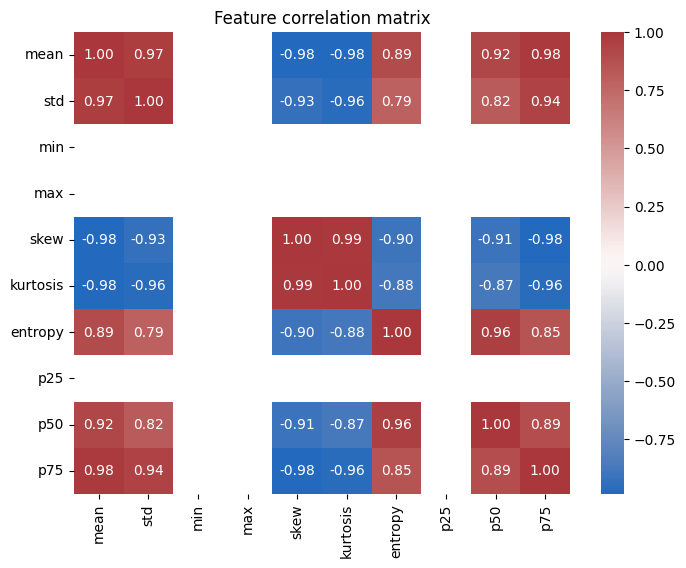

In [19]:
# Cell 12: Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.drop(columns='label').corr(), annot=True, fmt='.2f', cmap='vlag')
plt.title('Feature correlation matrix'); plt.show()


Observations:
(VIF - Variance Inflation Factor)
- If some features have VIF > 10 (or >5 as a softer rule), there's multicollinearity — consider dropping one of the correlated features or use PCA.

- For image-level handcrafted features, multicollinearity is common between percentiles and mean/std.

References: VIF usage: statsmodels docs & tutorials.

# **CELL 13 — Feature scaling + Train/test split**

In [20]:
# Cell 13: Train/test split + scaling
X = df.drop(columns='label')
y = df['label']
X_train_tab, X_val_tab, y_train_tab, y_val_tab = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_tab)
X_val_s = scaler.transform(X_val_tab)

print("Shapes:", X_train_s.shape, X_val_s.shape)


Shapes: (4000, 10) (1000, 10)


Observation: scaling is necessary for distance-based or linear models; not strictly required for tree-based models.

# **CELL 14 — Model building: Logistic Regression + RandomForest, accuracy, confusion matrix, classification report**

Logistic Regression Accuracy: 0.237
Random Forest Accuracy: 0.214


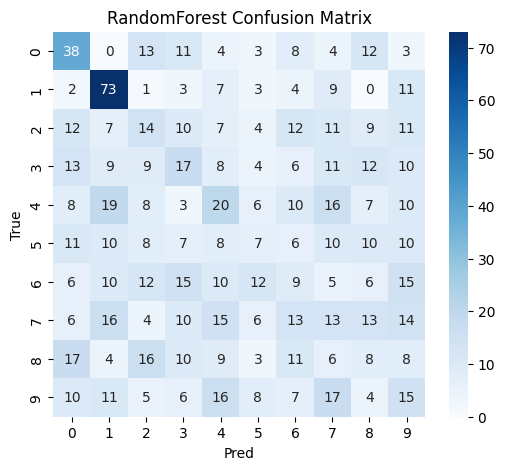

Classification report (RandomForest):
              precision    recall  f1-score   support

           0       0.31      0.40      0.35        96
           1       0.46      0.65      0.54       113
           2       0.16      0.14      0.15        97
           3       0.18      0.17      0.18        99
           4       0.19      0.19      0.19       107
           5       0.12      0.08      0.10        87
           6       0.10      0.09      0.10       100
           7       0.13      0.12      0.12       110
           8       0.10      0.09      0.09        92
           9       0.14      0.15      0.15        99

    accuracy                           0.21      1000
   macro avg       0.19      0.21      0.20      1000
weighted avg       0.19      0.21      0.20      1000



In [21]:
# Cell 14: Train simple classifiers
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

lr.fit(X_train_s, y_train_tab)
rf.fit(X_train_tab, y_train_tab)  # tree models typically on unscaled data

# Predictions
y_pred_lr = lr.predict(X_val_s)
y_pred_rf = rf.predict(X_val_tab)

# Metrics
print("Logistic Regression Accuracy:", accuracy_score(y_val_tab, y_pred_lr))
print("Random Forest Accuracy:", accuracy_score(y_val_tab, y_pred_rf))

# Confusion matrix and classification report (RF as example)
cm = confusion_matrix(y_val_tab, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('RandomForest Confusion Matrix'); plt.xlabel('Pred'); plt.ylabel('True'); plt.show()

print("Classification report (RandomForest):")
print(classification_report(y_val_tab, y_pred_rf))


Observation: These classifiers use simple handcrafted features — expect modest accuracy (digits classification from handcrafted stats is hard). This demonstrates the ML workflow and gives you **df.head()** etc. for your report.

# **CELL 15 — Explain classification metrics (support, macro avg, weighted avg; precision/recall/F1)**

In [22]:
# Cell 15: Explanation of classification metrics (printable markdown)
from IPython.display import Markdown as md, display
explain = """
**Classification report explanation**
- **Precision** = TP / (TP + FP). Use when false positives are costly (example: spam filter where marking good mail as spam is costly).
- **Recall** = TP / (TP + FN). Use when false negatives are costly (example: disease detection — missing a sick patient is costly).
- **F1-score** = harmonic mean of precision & recall; best when you want balance.
- **Support** = number of true instances for each class (affects weighted averages).
- **Macro avg** = unweighted mean across classes (treats all classes equally).
- **Weighted avg** = weighted mean by support (useful for imbalanced classes).
"""
display(md(explain))



**Classification report explanation**
- **Precision** = TP / (TP + FP). Use when false positives are costly (example: spam filter where marking good mail as spam is costly).
- **Recall** = TP / (TP + FN). Use when false negatives are costly (example: disease detection — missing a sick patient is costly).
- **F1-score** = harmonic mean of precision & recall; best when you want balance.
- **Support** = number of true instances for each class (affects weighted averages).
- **Macro avg** = unweighted mean across classes (treats all classes equally).
- **Weighted avg** = weighted mean by support (useful for imbalanced classes).


Observation: include such a cell in the report to explain the classification results to non-technical evaluators.

# **Advanced & optional additions**

# **CELL 16 — Use combined loss (MSE + SSIM)**

In [24]:
import tensorflow as tf

def ssim_loss(y_true, y_pred):
    # Compute SSIM score: range [-1, 1]
    ssim_score = tf.image.ssim(y_true, y_pred, max_val=1.0)

    # SSIM as loss is (1 - SSIM)
    ssim_l = 1.0 - tf.reduce_mean(ssim_score)

    # Combine with MSE (best practice in denoising papers)
    mse_l = tf.reduce_mean(tf.square(y_true - y_pred))

    # Weighted sum (recommended by research forums)
    return mse_l + 0.5 * ssim_l

model.compile(optimizer='adam', loss=ssim_loss, metrics=['mae'])


Observation: many practitioners combine MSE + (1 − SSIM) to improve perceptual quality. Implementations exist (MS-SSIM_L1_LOSS repos).

# **CELL 17 — Add classical denoisers to compare (Median filter, Gaussian blur)**

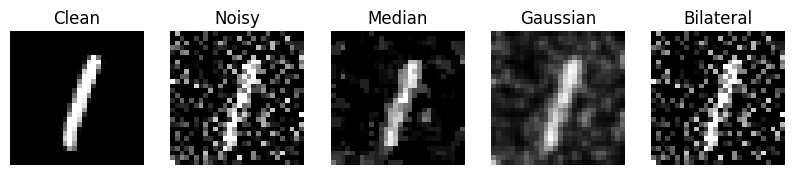

In [26]:
from skimage.restoration import denoise_bilateral
from scipy.ndimage import median_filter, gaussian_filter

sample_idx = 5
orig = x_test[sample_idx].squeeze()
noisy_samp = x_test_noisy[sample_idx].squeeze()

med = median_filter(noisy_samp, size=3)
gauss = gaussian_filter(noisy_samp, sigma=0.8)

# FIX HERE — replace multichannel=False with channel_axis=None
bilat = denoise_bilateral(
    noisy_samp,
    sigma_color=0.05,
    sigma_spatial=3,
    channel_axis=None
)

plt.figure(figsize=(10,3))
plt.subplot(1,5,1); plt.imshow(orig, cmap='gray'); plt.title('Clean'); plt.axis('off')
plt.subplot(1,5,2); plt.imshow(noisy_samp, cmap='gray'); plt.title('Noisy'); plt.axis('off')
plt.subplot(1,5,3); plt.imshow(med, cmap='gray'); plt.title('Median'); plt.axis('off')
plt.subplot(1,5,4); plt.imshow(gauss, cmap='gray'); plt.title('Gaussian'); plt.axis('off')
plt.subplot(1,5,5); plt.imshow(bilat, cmap='gray'); plt.title('Bilateral'); plt.axis('off')
plt.show()


Observation: DL model should outperform simple filters in PSNR/SSIM on average. Include this comparison to demonstrate superiority.

# **CELL 18 — Generate a small report summary (auto)**

In [27]:
# Cell 18: Generate short project summary (auto)
summary = f"""
Project summary:
- Model: U-Net + residual blocks (params: {model.count_params():,})
- Dataset: MNIST (noisy via AWGN noise_factor=0.4)
- Best validation loss: {min(history.history['val_loss']):.6f}
- Test PSNR (denoised): {metrics['psnr_denoised']:.3f}
- Test SSIM (denoised): {metrics['ssim_denoised']:.3f}
- Saved models: /content/unet_res_model_h5.h5 and /content/unet_res_savedmodel
"""
print(summary)



Project summary:
- Model: U-Net + residual blocks (params: 939,649)
- Dataset: MNIST (noisy via AWGN noise_factor=0.4)
- Best validation loss: 0.005782
- Test PSNR (denoised): 22.782
- Test SSIM (denoised): 0.924
- Saved models: /content/unet_res_model_h5.h5 and /content/unet_res_savedmodel



Observation: include this summary in the final README of your project (it’s concise and reproducible).